# Kaggle_Future_sales

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# from google.colab import drive
# import os
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
# %cd /content/gdrive/My Drive/Kaggle

In [4]:
# train=pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
# test=pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
train=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/sales_train.csv')
test=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/test.csv')

In [5]:
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


In [6]:
# shop=pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
# items=pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
# cat=pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
shop=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/shops.csv')
items=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/items.csv')
cat=pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/item_categories.csv')

# Data Preprocessing

In [7]:
#移除train中不需要的column，製作item_id對應的item_price表格
drop_elements=['date', 'date_block_num','item_cnt_day']
price_df = train.drop(drop_elements,axis=1)
price_df=price_df.sort_values(by=['shop_id','item_id'],ascending=[True,True])
price_df = price_df.drop_duplicates(['item_id'],) 
price_df.head(100)

,shop_id,item_id,item_price
173344,0,30,265.0
173403,0,31,434.0
40085,0,32,221.0
40089,0,33,347.0
40092,0,35,247.0
...,...,...,...
175117,0,1017,176.0
39992,0,1018,176.0
175116,0,1022,176.0
175115,0,1025,284.0


In [8]:
#合併表格，讓test的資料集也有item_price，遺失值約7%
test_p=pd.merge(test,price_df,how='left',on=['item_id']).drop('shop_id_y',axis=1)
test_p.isnull().sum()

ID                0
shop_id_x         0
item_id           0
item_price    15246
dtype: int64

In [9]:
#整理表格，將item_price的缺漏值填入(mean-std,mean+std)之間的隨機數
test_p.rename(columns={'shop_id_x':'shop_id'},inplace=True)
price_mean=np.mean(test_p['item_price'])
price_std=np.std(test_p['item_price'])
test_p['item_price']=test_p['item_price'].fillna(np.random.randint(price_mean - price_std,price_mean + price_std))
test_p.isnull().sum()

ID            0
shop_id       0
item_id       0
item_price    0
dtype: int64

In [10]:
#合併train和test
df=pd.concat([train,test_p],axis=0)

In [11]:
print(shop.shape)
print(items.shape)
print(cat.shape)

(60, 2)
(22170, 3)
(84, 2)


In [12]:
df['date_block_num']=df['date_block_num'].fillna(34)

In [13]:
train_num_afgp=df.iloc[0:2935849,:].groupby(['item_id','shop_id','date_block_num']).sum().shape[0]
test_num_afgp=df.iloc[2935849:,:].groupby(['item_id','shop_id','date_block_num']).sum().shape[0]
print('Train_num_afgp：',train_num_afgp)
print('Test_num_afgp：',test_num_afgp)
print('All_num_afgp：',train_num_afgp+test_num_afgp)

Train_num_afgp： 1609124
Test_num_afgp： 214200
All_num_afgp： 1823324


In [14]:
sum_of_month=df[['ID','date_block_num', 'shop_id', 'item_id','item_cnt_day']]
sum_of_month=sum_of_month.groupby(['item_id','shop_id','date_block_num']).sum()
sum_of_month.reset_index(inplace=True)
sum_of_month.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
sum_of_month.head(10)

,item_id,shop_id,date_block_num,ID,item_cnt_month
0,0,54,20.0,0.0,1.0
1,1,55,15.0,0.0,2.0
2,1,55,18.0,0.0,1.0
3,1,55,19.0,0.0,1.0
4,1,55,20.0,0.0,1.0
5,1,55,21.0,0.0,1.0
6,2,54,19.0,0.0,1.0
7,2,54,22.0,0.0,1.0
8,3,54,18.0,0.0,1.0
9,3,54,19.0,0.0,1.0


In [15]:
dfx=pd.merge(sum_of_month,price_df,how='left',on=['item_id']).drop('shop_id_y',axis=1)
dfx.rename(columns={'shop_id_x':'shop_id'},inplace=True)
dfx['item_price']=dfx['item_price'].fillna(np.random.randint(price_mean - price_std,price_mean + price_std))
dfx.isnull().sum()

item_id           0
shop_id           0
date_block_num    0
ID                0
item_cnt_month    0
item_price        0
dtype: int64

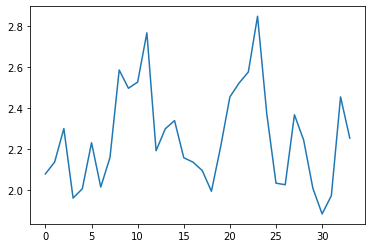

In [16]:
all_mean=dfx.groupby('date_block_num').mean()
all_mean.drop(34.0,axis=0,inplace=True)
#銷售時間的趨勢
plt.plot(all_mean.index,all_mean['item_cnt_month'])

In [17]:
#a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
#加入年份的feature
dfx.loc[(dfx['date_block_num'] <= 11),'Year']='2013'
dfx.loc[(dfx['date_block_num'] >= 12) & (dfx['date_block_num'] <= 23),'Year']='2014'
dfx.loc[(dfx['date_block_num'] >= 24) & (dfx['date_block_num'] <= 33),'Year']='2015'
dfx.head()

,item_id,shop_id,date_block_num,ID,item_cnt_month,item_price,Year
0,0,54,20.0,0.0,1.0,58.0,2014
1,1,55,15.0,0.0,2.0,4490.0,2014
2,1,55,18.0,0.0,1.0,4490.0,2014
3,1,55,19.0,0.0,1.0,4490.0,2014
4,1,55,20.0,0.0,1.0,4490.0,2014


In [18]:
#加入月份的feature
dfx.loc[(dfx['date_block_num'] == 0) | (dfx['date_block_num'] == 12) | (dfx['date_block_num'] == 24),'Month']=1
dfx.loc[(dfx['date_block_num'] == 1) | (dfx['date_block_num'] == 13) | (dfx['date_block_num'] == 25),'Month']=2
dfx.loc[(dfx['date_block_num'] == 2) | (dfx['date_block_num'] == 14) | (dfx['date_block_num'] == 26),'Month']=3
dfx.loc[(dfx['date_block_num'] == 3) | (dfx['date_block_num'] == 15) | (dfx['date_block_num'] == 27),'Month']=4
dfx.loc[(dfx['date_block_num'] == 4) | (dfx['date_block_num'] == 16) | (dfx['date_block_num'] == 28),'Month']=5
dfx.loc[(dfx['date_block_num'] == 5) | (dfx['date_block_num'] == 17) | (dfx['date_block_num'] == 29),'Month']=6
dfx.loc[(dfx['date_block_num'] == 6) | (dfx['date_block_num'] == 18) | (dfx['date_block_num'] == 30),'Month']=7
dfx.loc[(dfx['date_block_num'] == 7) | (dfx['date_block_num'] == 19) | (dfx['date_block_num'] == 31),'Month']=8
dfx.loc[(dfx['date_block_num'] == 8) | (dfx['date_block_num'] == 20) | (dfx['date_block_num'] == 32),'Month']=9
dfx.loc[(dfx['date_block_num'] == 9) | (dfx['date_block_num'] == 21) | (dfx['date_block_num'] == 33),'Month']=10
dfx.loc[(dfx['date_block_num'] == 10) | (dfx['date_block_num'] == 22),'Month']=11
dfx.loc[(dfx['date_block_num'] == 11) | (dfx['date_block_num'] == 23),'Month']=12
dfx.tail()

,item_id,shop_id,date_block_num,ID,item_cnt_month,item_price,Year,Month
1823319,22168,12,8.0,0.0,1.0,799.0,2013,9.0
1823320,22168,16,1.0,0.0,1.0,799.0,2013,2.0
1823321,22168,42,1.0,0.0,1.0,799.0,2013,2.0
1823322,22168,43,2.0,0.0,1.0,799.0,2013,3.0
1823323,22169,25,14.0,0.0,1.0,4349.0,2014,3.0


In [19]:
#Join所有表格
def mergecol(df):
    df2= pd.merge(df, items, how='left', on=['item_id'])
    df3= pd.merge(df2, shop, how='left', on=['shop_id'])
    df4= pd.merge(df3, cat, how='left', on=['item_category_id'])
    return df4
df4=mergecol(dfx)

In [20]:
df4.shape

(1823324, 12)

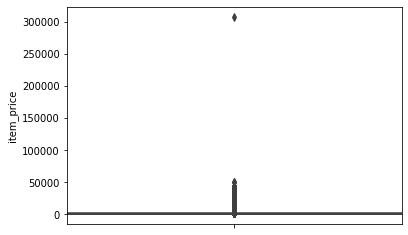

In [21]:
sns.boxplot(y="item_price", data=df4,width=200)

In [22]:
#price<0不合理，用mean填入
df4.loc[df4.item_price < 0, 'item_price']=np.mean(df4['item_price'])

In [23]:
print(df4.loc[df4.item_price > 200000, 'item_price']) 

547010    307980.0
Name: item_price, dtype: float64


In [24]:
#price>200000可能是outlier，用mean填入
df4.iloc[547010,5]=np.mean(df4['item_price'])

In [25]:
pd.set_option('display.float_format',lambda x : '%.2f' % x)
df4['item_price'].describe()

count   1823324.00
mean        809.82
std        1562.97
min           0.10
25%         199.00
50%         399.00
75%         899.00
max       50999.00
Name: item_price, dtype: float64

# Feature Engineering

In [26]:
# 列出item_name的名字找insight
# pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 200
# allname=pd.DataFrame(items['item_name'].unique())
# allname

In [27]:
#計算含有string的比例
print('PS4 ratio',df4['item_name'].str.contains('PS4').sum()/df4.shape[0])
print('PS3 ratio',df4['item_name'].str.contains('PS3').sum()/df4.shape[0])
print('CD ratio',df4['item_name'].str.contains('CD').sum()/df4.shape[0])
print('PC ratio',df4['item_name'].str.contains('PC').sum()/df4.shape[0])
print('Xbox ratio',df4['item_name'].str.contains('Xbox').sum()/df4.shape[0])
print('DVD ratio',df4['item_name'].str.contains('DVD').sum()/df4.shape[0])

PS4 ratio 0.02347196658410683
PS3 ratio 0.06330526006348844
CD ratio 0.06678681353396325
PC ratio 0.10967057966658696
Xbox ratio 0.05856611331831315
DVD ratio 0.03492522448012531


In [28]:
#製作feature，含有string為1，其餘為0
df4['PS3'] = df4["item_name"].apply(lambda x: 1 if 'PS3' in x else 0)
df4['PS4'] = df4["item_name"].apply(lambda x: 1 if 'PS4' in x else 0)
df4['DVD'] = df4["item_name"].apply(lambda x: 1 if 'DVD' in x else 0)
df4['CD'] = df4["item_name"].apply(lambda x: 1 if 'CD' in x else 0)
df4['PC'] = df4["item_name"].apply(lambda x: 1 if 'PC' in x else 0)
df4['Xbox'] = df4["item_name"].apply(lambda x: 1 if 'Xbox' in x else 0)
df4.tail()

,item_id,shop_id,date_block_num,ID,item_cnt_month,item_price,Year,Month,item_name,item_category_id,shop_name,item_category_name,PS3,PS4,DVD,CD,PC,Xbox
1823319,22168,12,8.00,0.00,1.00,799.00,2013,9.00,Яйцо для Little Inu,62,Интернет-магазин ЧС,"Подарки - Гаджеты, роботы, спорт",0,0,0,0,0,0
1823320,22168,16,1.00,0.00,1.00,799.00,2013,2.00,Яйцо для Little Inu,62,"Коломна ТЦ ""Рио""","Подарки - Гаджеты, роботы, спорт",0,0,0,0,0,0
1823321,22168,42,1.00,0.00,1.00,799.00,2013,2.00,Яйцо для Little Inu,62,"СПб ТК ""Невский Центр""","Подарки - Гаджеты, роботы, спорт",0,0,0,0,0,0
1823322,22168,43,2.00,0.00,1.00,799.00,2013,3.00,Яйцо для Little Inu,62,"СПб ТК ""Сенная""","Подарки - Гаджеты, роботы, спорт",0,0,0,0,0,0
1823323,22169,25,14.00,0.00,1.00,4349.00,2014,3.00,Яйцо дракона (Игра престолов),69,"Москва ТРК ""Атриум""",Подарки - Сувениры,0,0,0,0,0,0


In [29]:
#把test的年份填入2015，月份填入11
df4['Year']=df4['Year'].fillna('2015')
df4['Month']=df4['Month'].fillna(11)

In [30]:
df4.loc[(df4['item_price'] <250) ,'price_g']=0
df4.loc[(df4['item_price'] >=250) & (df4['item_price'] <1000),'price_g']=1
df4.loc[(df4['item_price'] >=1000) ,'price_g']=2

In [31]:
# df4 = pd.get_dummies(data=df4,columns=['Year'])
# df4 = pd.get_dummies(data=df4,columns=['Month'])

In [32]:
before_cnt=df4[df4['date_block_num']!=34][['date_block_num', 'shop_id', 'item_id','item_category_id','item_cnt_month']]
before_cnt.shape

(1609124, 5)

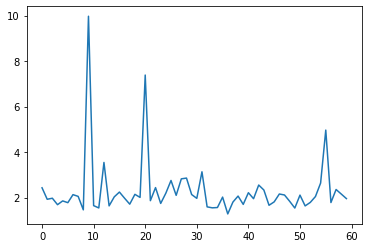

In [33]:
shop_mean=before_cnt.groupby(["shop_id"]).mean()
plt.plot(shop_mean.index,shop_mean['item_cnt_month'])

In [34]:
afsort=shop_mean['item_cnt_month'].sort_values(ascending=False)
afsort=pd.DataFrame(afsort)

In [35]:
mean_cnt_shopid=np.mean(shop_mean['item_cnt_month'])
std_cnt_shopid=np.std(shop_mean['item_cnt_month'])
Mean_plus=mean_cnt_shopid+1.5*std_cnt_shopid
Mean_minus=mean_cnt_shopid-1.5*std_cnt_shopid
print('Mean+1.5SD：',Mean_plus)
print('Mean-1.5SD：',Mean_minus)

Mean+1.5SD： 4.296999737547448
Mean-1.5SD： 0.30853576864607657


In [36]:
fil=(afsort['item_cnt_month']>Mean_plus)
fil2=(afsort['item_cnt_month']<Mean_minus)
print(afsort[fil])
print(afsort[fil2])

         item_cnt_month
shop_id                
9                  9.97
20                 7.39
55                 4.97
Empty DataFrame
Columns: [item_cnt_month]
Index: []


In [37]:
df4['shopid_9'] = df4["shop_id"].apply(lambda x: 1 if x==9  else 0)
df4['shopid_20'] = df4["shop_id"].apply(lambda x: 1 if x==20 else 0)
df4['shopid_55'] = df4["shop_id"].apply(lambda x: 1 if x==55 else 0)

In [38]:
print(df4.loc[df4.shopid_9==1]['shopid_9'].count()/df4.shape[0])
print(df4.loc[df4.shopid_20==1]['shopid_20'].count()/df4.shape[0])
print(df4.loc[df4.shopid_55==1]['shopid_55'].count()/df4.shape[0])

0.0008725821631262463
0.00043601685712468
0.009798587634452242


In [39]:
# df4.drop(['date_block_num_y'],axis=1,inplace=True)
# df4.rename(columns={'date_block_num_x':'date_block_num'},inplace=True)

In [40]:
df4['Year']=df4['Year'].astype('int')

In [41]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
#過去1、2、3、6、12個月該item在該店的月銷量
df5=lag_feature(df4,[1,2,3,6,12],'item_cnt_month')

In [42]:
#過去1、2、3個月該item在所有店平均月銷量
avg_item_cnt=df5.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
avg_item_cnt.columns = [ 'item_avg_item_cnt' ]
avg_item_cnt.reset_index(inplace=True)
df6=pd.merge(df5, avg_item_cnt, on=['date_block_num','item_id'], how='left')
df7=lag_feature(df6,[1,2,3],'item_avg_item_cnt')
df7.drop('item_avg_item_cnt',axis=1,inplace=True)

In [43]:
#過去1、2、3個月該item所屬的category所有店的平均月銷量
avg_cat_cnt=df7.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
avg_cat_cnt.columns = [ 'cat_avg_item_cnt' ]
avg_cat_cnt.reset_index(inplace=True)
df8=pd.merge(df7, avg_cat_cnt, on=['date_block_num','item_category_id'], how='left')
df9=lag_feature(df8,[1,2,3],'cat_avg_item_cnt')
df9.drop('cat_avg_item_cnt',axis=1,inplace=True)

In [44]:
#過去1、2、3個月該item所屬的shop的平均月銷量
avg_shop_cnt=df9.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
avg_shop_cnt.columns = [ 'shop_avg_item_cnt' ]
avg_shop_cnt.reset_index(inplace=True)
df10=pd.merge(df9, avg_shop_cnt, on=['date_block_num','shop_id'], how='left')
df11=lag_feature(df10,[1,2,3],'shop_avg_item_cnt')
df11.drop('shop_avg_item_cnt',axis=1,inplace=True)

In [45]:
#過去1、2、3個月該item所屬的category在該item所屬shop的平均月銷量
shop_avg_cat_cnt = df11.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
shop_avg_cat_cnt.columns = ['shop_cat_avg_item_cnt']
shop_avg_cat_cnt.reset_index(inplace=True)
df12 = pd.merge(df11, shop_avg_cat_cnt, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
df13 = lag_feature(df12, [1,2,3], 'shop_cat_avg_item_cnt')
df13.drop(['shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [46]:
df13.isnull().sum()

item_id                              0
shop_id                              0
date_block_num                       0
ID                                   0
item_cnt_month                       0
item_price                           0
Year                                 0
Month                                0
item_name                            0
item_category_id                     0
shop_name                            0
item_category_name                   0
PS3                                  0
PS4                                  0
DVD                                  0
CD                                   0
PC                                   0
Xbox                                 0
price_g                              0
shopid_9                             0
shopid_20                            0
shopid_55                            0
item_cnt_month_lag_1           1117906
item_cnt_month_lag_2           1207011
item_cnt_month_lag_3           1276526
item_cnt_month_lag_6     

In [47]:
def fill_lag(df,cols,lag_nums):
    for k in cols:
        for i in lag_nums:
            col_name=str(k)+'_lag_'+str(i)
            df[col_name]=df[col_name].fillna(0)
    return df
df14=fill_lag(df13,['item_cnt_month'],[1,2,3,6,12])
df15=fill_lag(df14,['item_avg_item_cnt','cat_avg_item_cnt','shop_cat_avg_item_cnt','shop_avg_item_cnt'],[1,2,3])

In [48]:
# df15 = pd.get_dummies(data=df15,columns=['Year'])
# df15 = pd.get_dummies(data=df15,columns=['Month'])

In [49]:
df15.isnull().sum()

item_id                        0
shop_id                        0
date_block_num                 0
ID                             0
item_cnt_month                 0
item_price                     0
Year                           0
Month                          0
item_name                      0
item_category_id               0
shop_name                      0
item_category_name             0
PS3                            0
PS4                            0
DVD                            0
CD                             0
PC                             0
Xbox                           0
price_g                        0
shopid_9                       0
shopid_20                      0
shopid_55                      0
item_cnt_month_lag_1           0
item_cnt_month_lag_2           0
item_cnt_month_lag_3           0
item_cnt_month_lag_6           0
item_cnt_month_lag_12          0
item_avg_item_cnt_lag_1        0
item_avg_item_cnt_lag_2        0
item_avg_item_cnt_lag_3        0
cat_avg_it

In [50]:
final_df=df15

In [51]:
final_df.columns

Index(['item_id', 'shop_id', 'date_block_num', 'ID', 'item_cnt_month',
       'item_price', 'Year', 'Month', 'item_name', 'item_category_id',
       'shop_name', 'item_category_name', 'PS3', 'PS4', 'DVD', 'CD', 'PC',
       'Xbox', 'price_g', 'shopid_9', 'shopid_20', 'shopid_55',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_avg_item_cnt_lag_1', 'item_avg_item_cnt_lag_2',
       'item_avg_item_cnt_lag_3', 'cat_avg_item_cnt_lag_1',
       'cat_avg_item_cnt_lag_2', 'cat_avg_item_cnt_lag_3',
       'shop_avg_item_cnt_lag_1', 'shop_avg_item_cnt_lag_2',
       'shop_avg_item_cnt_lag_3', 'shop_cat_avg_item_cnt_lag_1',
       'shop_cat_avg_item_cnt_lag_2', 'shop_cat_avg_item_cnt_lag_3'],
      dtype='object')

# Model Training and cross validation

In [52]:
train_data=final_df[final_df['date_block_num']<33]
valid_data=final_df.loc[(final_df['date_block_num']>=33) & (final_df['date_block_num']<34)]

In [53]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
features=['item_category_id', 'PS3', 'PS4', 'DVD', 'CD', 'PC',
       'Xbox', 'price_g', 'shopid_9', 'shopid_20', 'shopid_55','item_price','item_id','item_category_id','item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3',
          'item_cnt_month_lag_6','item_cnt_month_lag_12',
          'item_avg_item_cnt_lag_1','item_avg_item_cnt_lag_2','cat_avg_item_cnt_lag_1','cat_avg_item_cnt_lag_2'
         ,'shop_cat_avg_item_cnt_lag_1','shop_cat_avg_item_cnt_lag_2',
         'item_category_id','shop_avg_item_cnt_lag_1','shop_avg_item_cnt_lag_2','shop_avg_item_cnt_lag_3','price_g',
         'Year','Month']
target=['item_cnt_month']
X_train =train_data[features]
y_train =train_data[target]
X_val =valid_data[features]
y_val =valid_data[target]
print('There are total',len(features),'features')

There are total 32 features


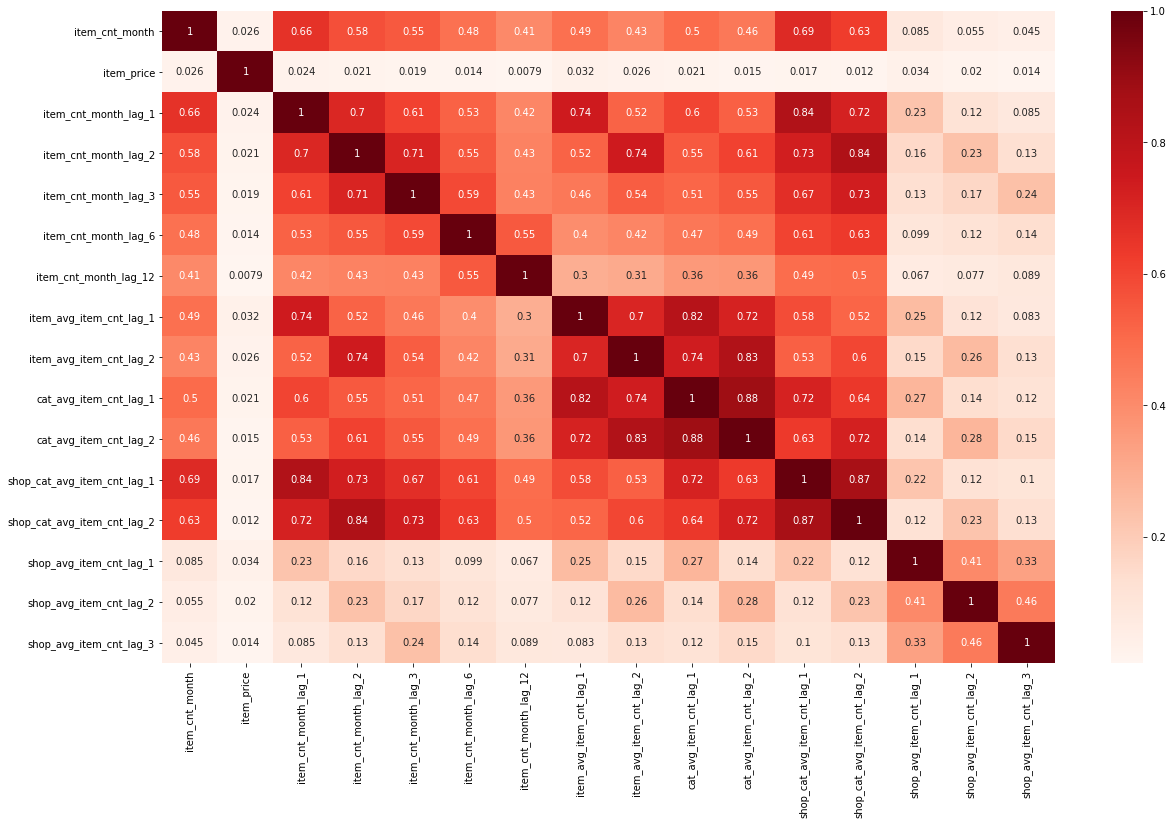

In [54]:
col_cor=train_data[['item_cnt_month','item_price',
        'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3',
          'item_cnt_month_lag_6','item_cnt_month_lag_12',
          'item_avg_item_cnt_lag_1','item_avg_item_cnt_lag_2','cat_avg_item_cnt_lag_1',
                    'cat_avg_item_cnt_lag_2','shop_cat_avg_item_cnt_lag_1','shop_cat_avg_item_cnt_lag_2',
                   'shop_avg_item_cnt_lag_1','shop_avg_item_cnt_lag_2','shop_avg_item_cnt_lag_3']]
plt.figure(figsize=(20,12))
cor = col_cor.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

(1577593, 4)
[9.47750270e-01 5.22216600e-02 1.66078196e-05 7.19086613e-06]


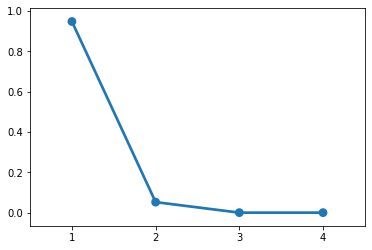

In [55]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=4)
X_train_pca=pca.fit_transform(X_train)
print(X_train_pca.shape)
print(pca.explained_variance_ratio_)
#PCA結果視覺化
pc=list(range(1,X_train_pca.shape[1]+1))
explain_pca=pca.explained_variance_ratio_
dic_pointplot_PCA={"PC":pc,"Explained Variance Ratio":explain_pca}
sns.pointplot(x="PC",y="Explained Variance Ratio",data=dic_pointplot_PCA)
X_val_pca=pca.transform(X_val)

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
ts = time.time()

lgb=LGBMRegressor(n_estimators=100,learning_rate=0.1,max_depth=10)

lgb_model=lgb.fit(X_train_pca,y_train,eval_metric="rmse",    
                 eval_set=[(X_train_pca, y_train), (X_val_pca, y_val)])
time.time() - ts

/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's rmse: 8.06845	training's l2: 65.0999	valid_1's rmse: 14.3051	valid_1's l2: 204.635
[2]	training's rmse: 7.70867	training's l2: 59.4237	valid_1's rmse: 14.1206	valid_1's l2: 199.391
[3]	training's rmse: 7.3999	training's l2: 54.7584	valid_1's rmse: 13.989	valid_1's l2: 195.691
[4]	training's rmse: 7.13915	training's l2: 50.9674	valid_1's rmse: 13.8815	valid_1's l2: 192.696
[5]	training's rmse: 6.92242	training's l2: 47.9198	valid_1's rmse: 13.7522	valid_1's l2: 189.123
[6]	training's rmse: 6.7427	training's l2: 45.464	valid_1's rmse: 13.649	valid_1's l2: 186.294
[7]	training's rmse: 6.58241	training's l2: 43.3282	valid_1's rmse: 13.5202	valid_1's l2: 182.796
[8]	training's rmse: 6.45676	training's l2: 41.6898	valid_1's rmse: 13.4358	valid_1's l2: 180.522
[9]	training's rmse: 6.33132	training's l2: 40.0856	valid_1's rmse: 13.3378	valid_1's l2: 177.897
[10]	training's rmse: 6.24509	training's l2: 39.0011	valid_1's rmse: 13.2751	valid_1's l2: 176.229
[11]	training's rmse: 6.

[86]	training's rmse: 5.47387	training's l2: 29.9632	valid_1's rmse: 12.6671	valid_1's l2: 160.454
[87]	training's rmse: 5.47243	training's l2: 29.9475	valid_1's rmse: 12.6662	valid_1's l2: 160.432
[88]	training's rmse: 5.47073	training's l2: 29.9289	valid_1's rmse: 12.6664	valid_1's l2: 160.439
[89]	training's rmse: 5.468	training's l2: 29.8991	valid_1's rmse: 12.6631	valid_1's l2: 160.355
[90]	training's rmse: 5.46425	training's l2: 29.8581	valid_1's rmse: 12.6639	valid_1's l2: 160.373
[91]	training's rmse: 5.46205	training's l2: 29.834	valid_1's rmse: 12.6639	valid_1's l2: 160.373
[92]	training's rmse: 5.46086	training's l2: 29.8209	valid_1's rmse: 12.6637	valid_1's l2: 160.37
[93]	training's rmse: 5.45821	training's l2: 29.7921	valid_1's rmse: 12.6649	valid_1's l2: 160.399
[94]	training's rmse: 5.45675	training's l2: 29.7761	valid_1's rmse: 12.665	valid_1's l2: 160.403
[95]	training's rmse: 5.45526	training's l2: 29.7599	valid_1's rmse: 12.6628	valid_1's l2: 160.346
[96]	training's

12.229589700698853

/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: more than one metric available, picking one to plot.
  


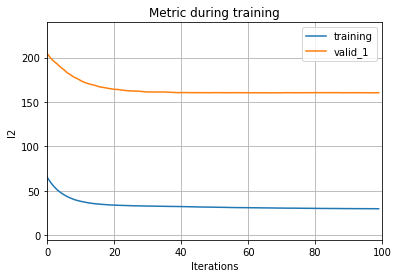

In [57]:
from lightgbm import plot_metric
plot_metric(lgb_model)

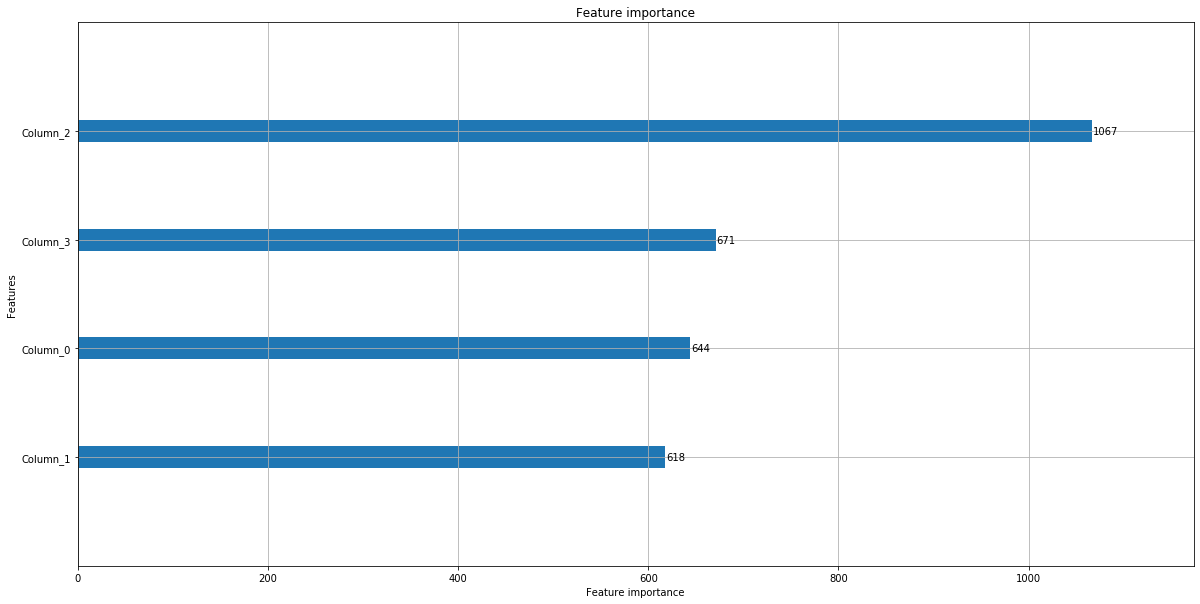

In [58]:
from xgboost import plot_importance
from lightgbm import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(lgb_model,(20,10))

In [59]:
test_data=final_df[final_df['date_block_num']==34]
test_data.set_index("ID" , inplace=True)
test_data2=test_data.sort_values(by='ID',ascending=True)
X_test =test_data2[features]

X_test=pca.transform(X_test)
lgb_predict = lgb_model.predict(X_test)

In [60]:
submit = pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/competitive-data-science-predict-future-sales/sample_submission.csv')
submit['item_cnt_month'] =lgb_predict
submit.to_csv('/Users/jimmyfu87/JupyterNotebook/Submit_result/submit_sales_lgb.csv', index= False)